# Preprocessing and clustering Satellite cells samples

Here is the script used for scRNAseq of sorted satellite cells from human muscles for each individual sample based on the SCANPY tutorial https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         9.0.1
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
bottleneck                  1.3.2
cffi                        1.15.0
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing    

In [3]:
results_file = 'write_paper/Pectoralis21F.h5ad'  # the file that will store the analysis results

Load the data

In [4]:
adata = sc.read_10x_mtx(
    '/Volumes/LaCie/PomLab/Python/scanpy-tutorials-master/395_Pectoralis21F/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/Volumes-LaCie-PomLab-Python-scanpy-tutorials-master-395_Pectoralis21F-filtered_feature_bc_matrix-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 6897 × 33694
    var: 'gene_ids', 'feature_types'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


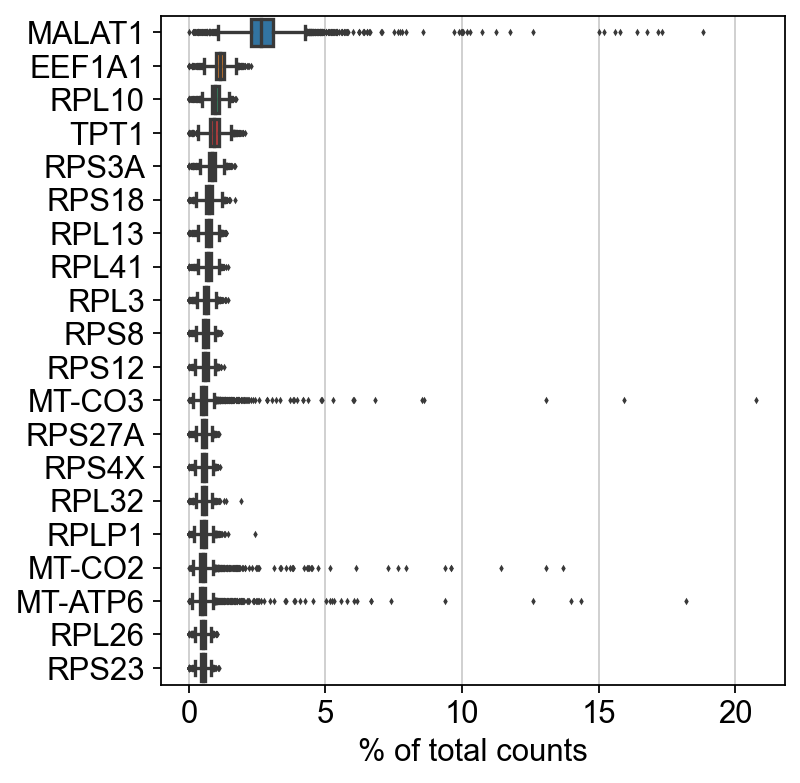

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering.

In [8]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)

filtered out 24 cells that have less than 500 genes expressed
filtered out 15603 genes that are detected in less than 5 cells


Investigate mitochondrial genes for quality control.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

/opt/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


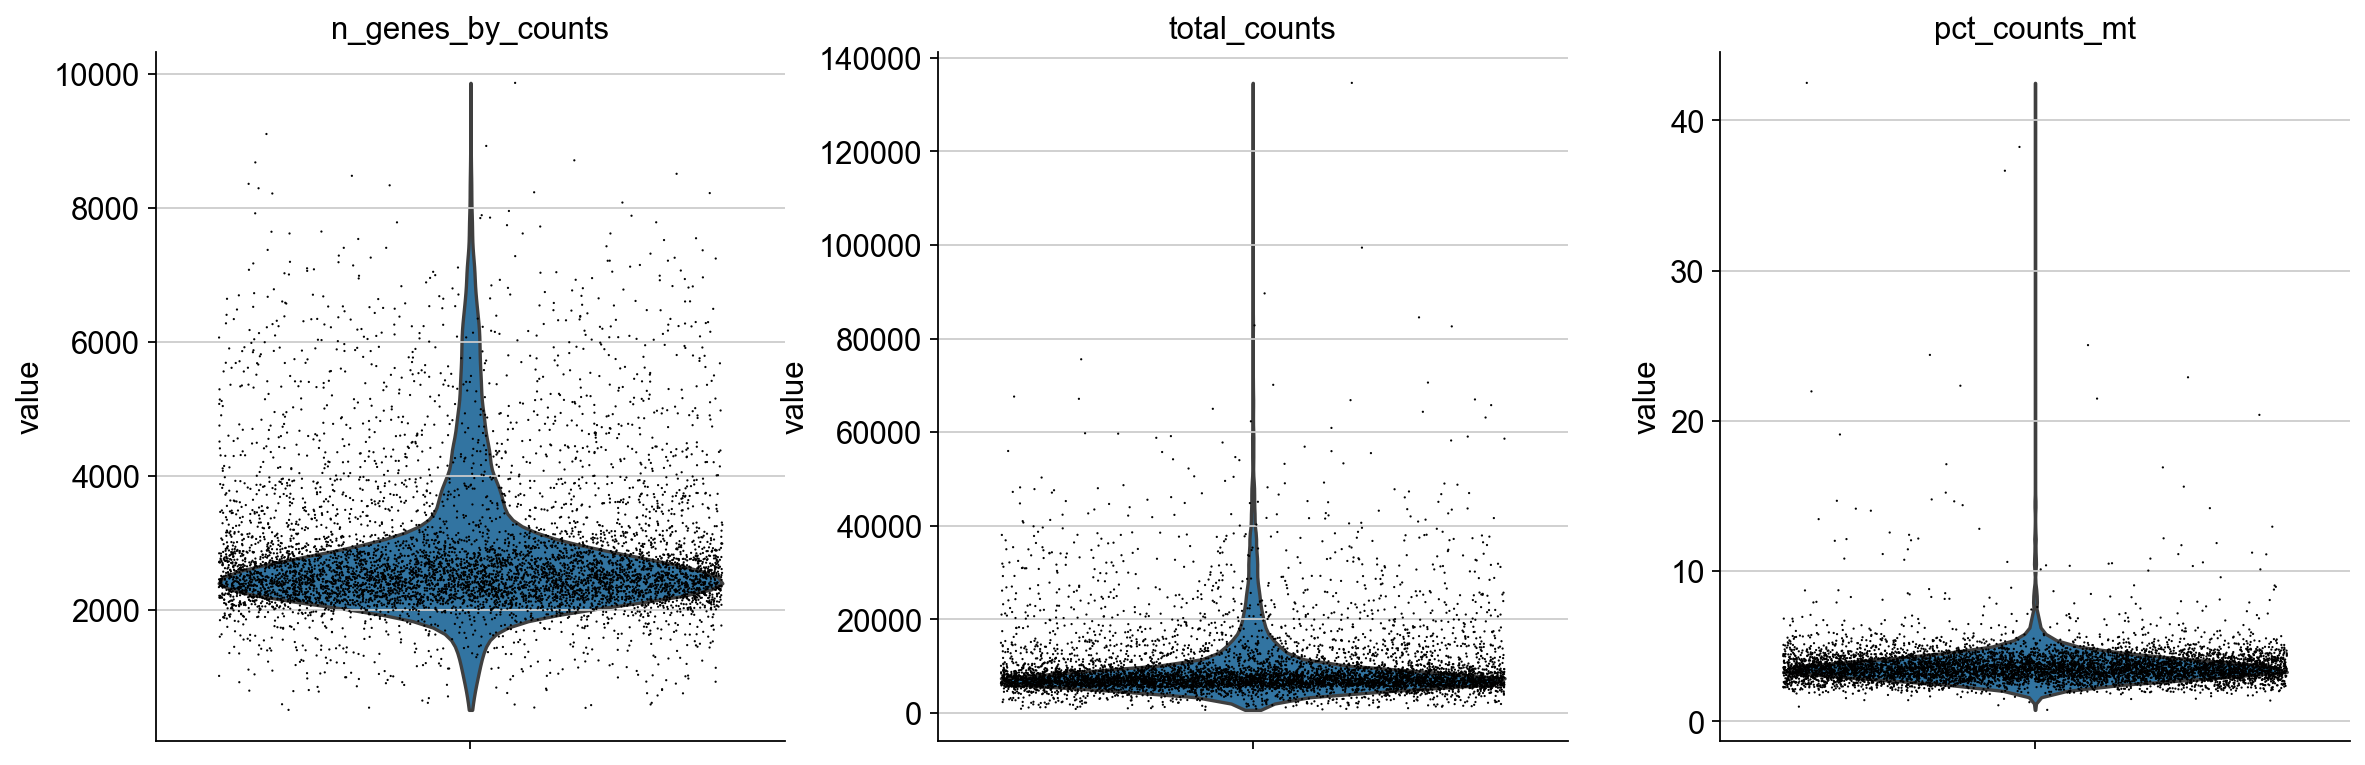

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

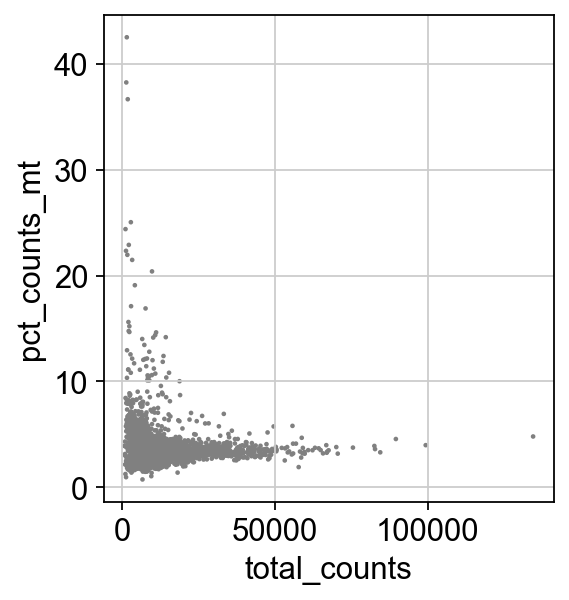

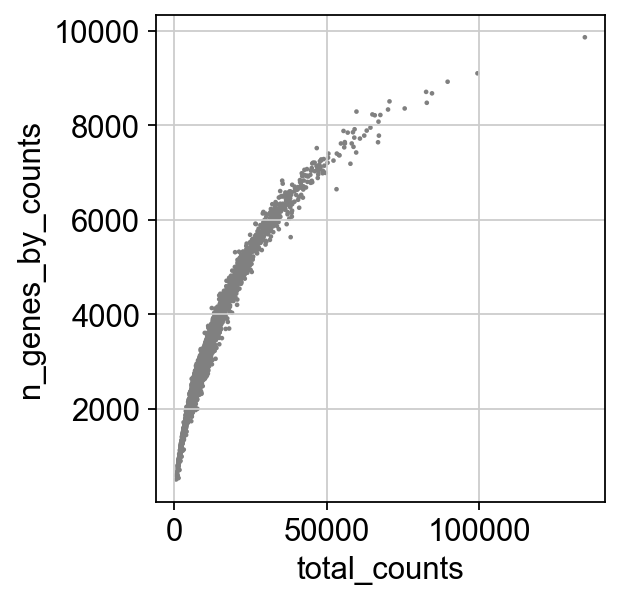

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/opt/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data.

In [14]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


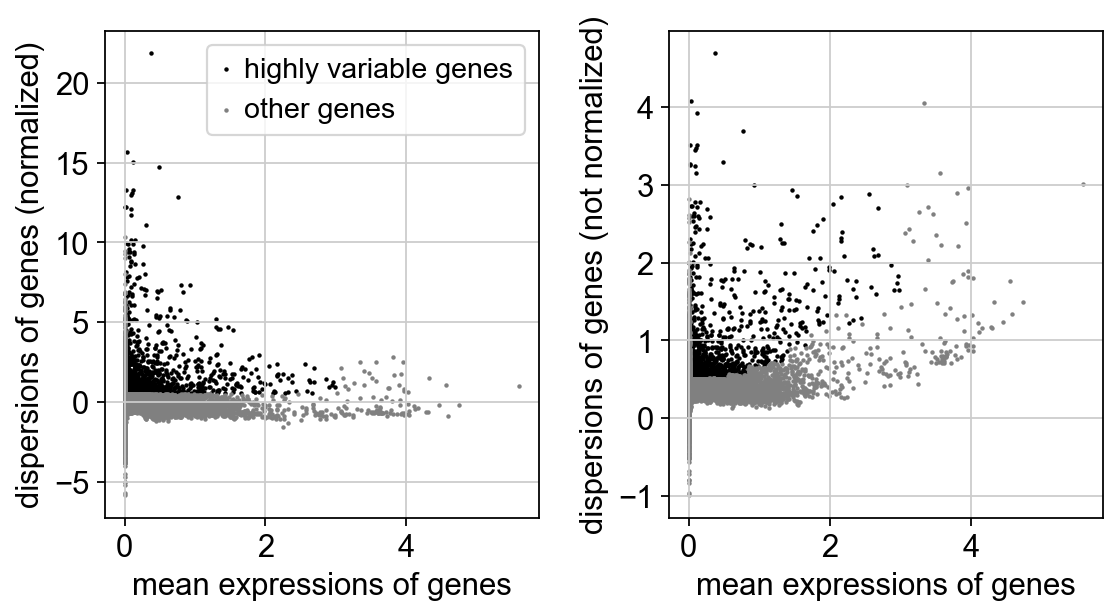

In [16]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [17]:
adata.raw = adata

Actually do the filtering

In [18]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [19]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


    finished (0:00:19)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [20]:
sc.pp.scale(adata, max_value=10)

Save results

In [21]:
adata.write(results_file)

In [22]:
adata

AnnData object with n_obs × n_vars = 6794 × 1713
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

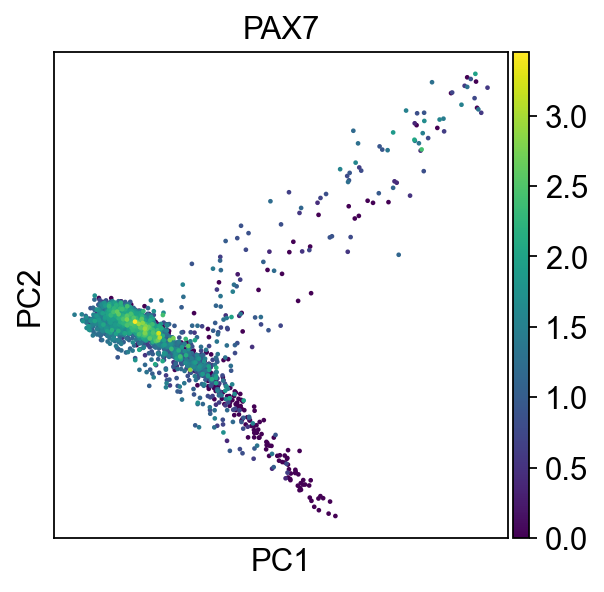

In [24]:
sc.pl.pca(adata, color='PAX7')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

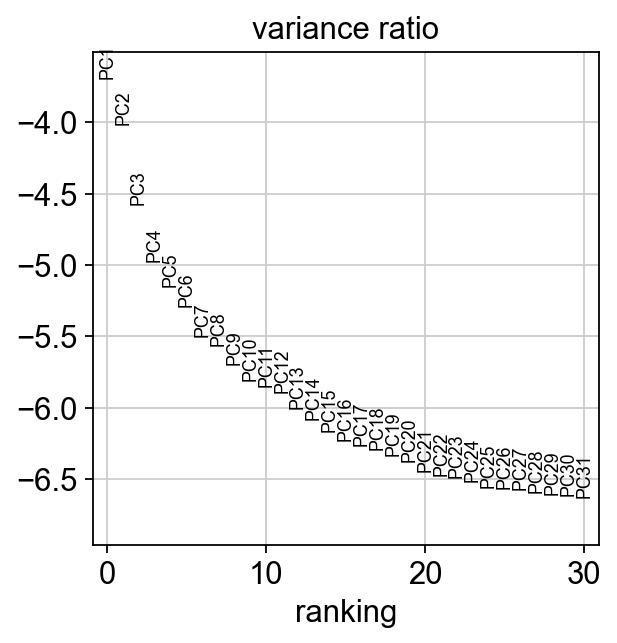

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 6794 × 1713
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


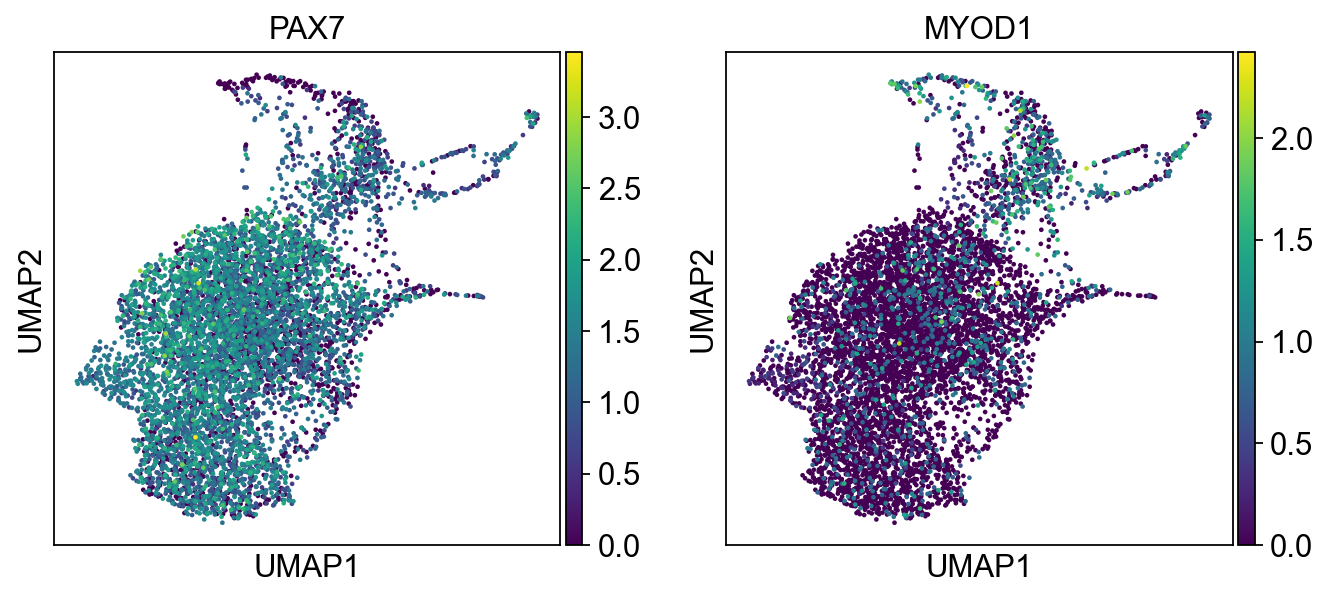

In [30]:
sc.pl.umap(adata, color=['PAX7', 'MYOD1'], ncols = 2)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [31]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

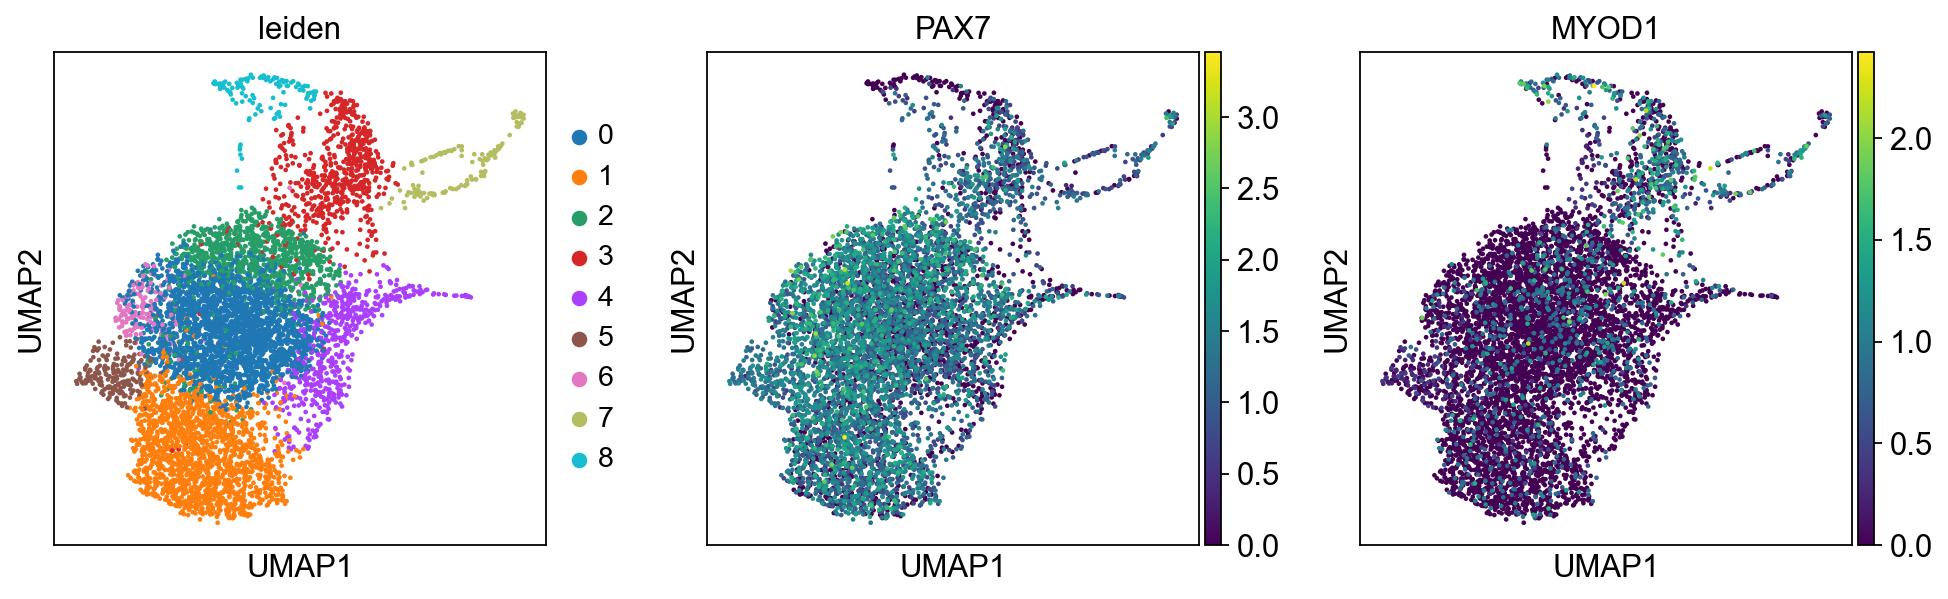

In [32]:
sc.pl.umap(adata, color=['leiden', 'PAX7', 'MYOD1'])

Save the result.

In [33]:
adata.write(results_file)